In [184]:
import numpy as np 
from sklearn.linear_model import LinearRegression
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.ar_model import AutoReg
import matplotlib.dates as mdates
import datetime
from sklearn.metrics import mean_squared_error


In [162]:
df = pd.read_csv('coin_Cardano.csv',header=0, parse_dates=[0])

In [163]:
df.head()

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Cardano,ADA,2017-10-02 23:59:59,0.030088,0.019969,0.024607,0.025932,57641300.0,6.288991e+08
1,2,Cardano,ADA,2017-10-03 23:59:59,0.027425,0.020690,0.025757,0.020816,16997800.0,5.396927e+08
2,3,Cardano,ADA,2017-10-04 23:59:59,0.022806,0.020864,0.020864,0.021931,9000050.0,5.686195e+08
3,4,Cardano,ADA,2017-10-05 23:59:59,0.022154,0.020859,0.021951,0.021489,5562510.0,5.571390e+08
4,5,Cardano,ADA,2017-10-06 23:59:59,0.021542,0.018360,0.021359,0.018539,7780710.0,4.806646e+08


In [164]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [165]:
df = df[['Close']]

In [166]:
df.head()

,Close
Date,
2017-10-02 23:59:59,0.025932
2017-10-03 23:59:59,0.020816
2017-10-04 23:59:59,0.021931
2017-10-05 23:59:59,0.021489
2017-10-06 23:59:59,0.018539


In [167]:
# a variablle for predicting 'n' days out into the future
forecast_out = 2 
#create another column (the target) shifted 'n' units up 
df['Prediction'] = df['Close'].shift(-forecast_out)
print(df.tail())

                        Close  Prediction
Date                                     
2021-02-23 23:59:59  0.954709    1.079116
2021-02-24 23:59:59  1.051657    1.241105
2021-02-25 23:59:59  1.079116    1.324860
2021-02-26 23:59:59  1.241105         NaN
2021-02-27 23:59:59  1.324860         NaN


In [168]:
#creating the independend data set (X)
#convert dataframe to a numpy array
X = np.array(df.drop(['Prediction'],1))
#remove last '2' rows
X = X[:-forecast_out]
print(X)

[[0.0259318 ]
 [0.0208158 ]
 [0.0219315 ]
 ...
 [0.95470914]
 [1.05165663]
 [1.0791162 ]]


In [169]:
#create the dependent data set (y)
y = np.array(df['Prediction'])
y = y[:-forecast_out]
print(y)

[0.0219315  0.0214887  0.0185391  ... 1.0791162  1.24110539 1.32486029]


In [170]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [171]:
lr = LinearRegression()
lr.fit(x_train, y_train)

LinearRegression()

In [172]:
lr_confidence = lr.score(x_test, y_test)
print('lr_confidence: ', lr_confidence )

lr_confidence:  0.9521854231708676


In [173]:
# set x_forecast equal to the last 2 rows of the original data set from Close column
x_forecast = np.array(df.drop(['Prediction'],1))[-forecast_out:]
print(x_forecast)

[[1.24110539]
 [1.32486029]]


In [174]:
# print lr model prediction for the next  days
lr_prediction = lr.predict(x_forecast)
print(lr_prediction)

[1.25579087 1.3405315 ]


In [175]:
df.head()

,Close,Prediction
Date,,
2017-10-02 23:59:59,0.025932,0.021931
2017-10-03 23:59:59,0.020816,0.021489
2017-10-04 23:59:59,0.021931,0.018539
2017-10-05 23:59:59,0.021489,0.020941
2017-10-06 23:59:59,0.018539,0.020477


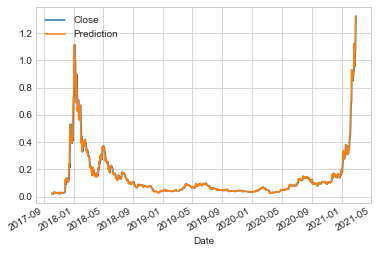

In [176]:
df.plot()

In [146]:
def ma21(crypto):
    return crypto.Close.rolling(21).mean()
# Bollinger Bands    
def bollinger_bands(crypto, window=21):
    rolling_mean = crypto.Close.rolling(window).mean()
    rolling_std = crypto.Close.rolling(window).std()
    upper_band = rolling_mean + (rolling_std*2)
    lower_band = rolling_mean - (rolling_std*2)
    return upper_band, lower_band

In [147]:
df['MACD'] = df.Close.ewm(span=12, adjust=False).mean() - df.Close.ewm(span=26, adjust=False).mean()
df['Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
df['MA21'] = ma21(df)
df['Upper_band'], df['Lower_band'] = bollinger_bands(df)
df.dropna(inplace=True)

In [148]:
def trading_history(stock, net, std=2):    
    
    # Bollinger band plot with EMA and original historical data
    plt.figure(figsize=(16,5))
    plt.style.use('seaborn-whitegrid')
    plt.plot(stock.index, stock.Close, color='#3388cf', label='Price')
    plt.plot(stock.index, stock.MA21, color='#ad6eff', label='Moving Average (21 days)')
    plt.plot(stock.index, stock.Upper_band, color='#ffbd74', alpha=0.3)
    plt.plot(stock.index, stock.Lower_band, color='#ffa33f', alpha=0.3)
    plt.fill_between(stock.index, stock.Upper_band, stock.Lower_band, color='#ffa33f', alpha=0.1, label='Bollinger Band ({} STD)'.format(std))
    
    plt.title('Trading History', fontSize=15)
    plt.ylabel('Price', fontSize=12)
    plt.xlim([stock.index.min(), stock.index.max()])
    
    for i in net:
        if i[2] == 1: color = '#ff005e'
        else: color = '#4bd81d'
        plt.plot_date(i[0], i[1], color=color)
        
    plt.plot_date([],[],label='Buy', c='#ff005e')
    plt.plot_date([],[],label='Sell', c='#4bd81d')
        
    plt.legend(frameon=True, loc=1, ncol=1, fontsize=10, borderpad=.6)
    plt.show()

In [149]:
def macd_trading(stock, budget=15000, show_graph=True, show_return=True):
    
    state_check = lambda x, y: 1 if x > y else 0
    stock = stock.reset_index()    
    money = budget
    prev_state = state_check(stock.loc[0].MACD, stock.loc[0].Signal)
    stock_amt = 0
    net = []

    for i in range(1, len(stock)):

        today = stock.iloc[i]
        state = state_check(today.MACD, today.Signal)

        if state != prev_state:

            # BUY
            if (today.MACD > today.Signal) and (money != 0):
                stock_amt = int(money / today.Close)
                money = 0
                net.append([today.Date, today.Close, 1, stock_amt * today.Close])

            # SELL
            if (today.MACD < today.Signal) and (stock_amt != 0):
                money = stock_amt * today.Close
                stock_amt = 0
                net.append([today.Date, today.Close, 0, money])

        prev_state = state
    
    profit = net[-1][3] - budget
    
    if show_return == True:
        print('Number of Trades: {}'.format(len(net)))
        print('Time Frame: {} days'.format((net[-1][0] - net[0][0]).days))
        print('Profit: ${:.2f} | {}%'.format(profit, round(profit/budget*100, 2)))

    if show_graph == True:
        trading_history(stock.set_index('Date'), net)

    return profit, net 

Number of Trades: 4
Time Frame: 34 days
Profit: $10849.38 | 72.33%


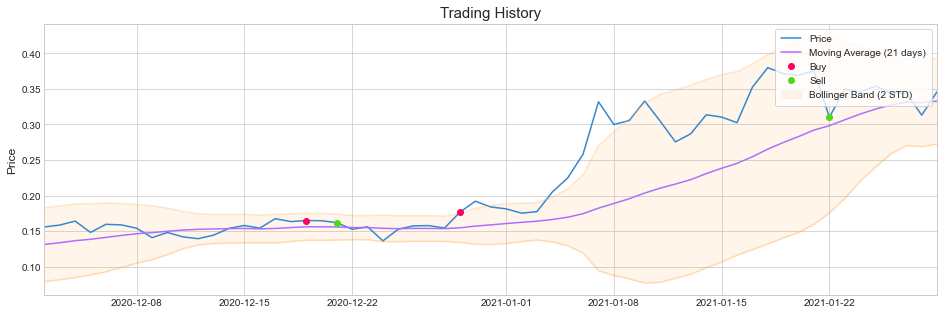

In [159]:
profit, trades = macd_trading(df.loc['2020-12':'2021-02'])

In [110]:
df.tail()

,Close,Prediction,MACD,Signal,MA21,Upper_band,Lower_band
Date,,,,,,,
2021-02-21 23:59:59,1.100520,0.954709,0.162134,0.144908,0.769127,1.211663,0.326591
2021-02-22 23:59:59,1.099151,1.051657,0.165147,0.148956,0.802323,1.233648,0.370998
2021-02-23 23:59:59,0.954709,1.079116,0.154102,0.149985,0.827488,1.227162,0.427814
2021-02-24 23:59:59,1.051657,1.241105,0.151426,0.150273,0.856548,1.225912,0.487184
2021-02-25 23:59:59,1.079116,1.324860,0.149795,0.150178,0.886932,1.215462,0.558401


In [177]:
def hit_rate(true, pred):
    is_neg = lambda x: 0 if x > 0 else 1
    pos_true = []
    pos_hat = []
    for t in range(len(true)-1):
        pos_true.append(is_neg(np.sign(true[t] - true[t+1])))
        pos_hat.append(is_neg(np.sign(pred[t] - pred[t+1])))
    subtracted = np.abs(np.subtract(pos_hat, pos_true))
    rate = 1 - sum(subtracted)/len(subtracted)
    return rate

def find_returns(true, pred):
    ret_true = []
    ret_hat = []
    for t in range(len(true)-1):
        ret_true.append(((true[t+1] - true[t])/true[t])*100)
        ret_hat.append(((pred[t+1] - pred[t])/pred[t])*100)
    mse = mean_squared_error(ret_true, ret_hat)
    return ret_true, ret_hat, mse
        

def model_selection(data, forecast, dates, optimization='RET'):
    X_train, X_test = data[1:len(data)-forecast], data[len(data)-forecast:]
    dates_test = dates[len(dates)-forecast:]
    # find lag values which maximize hit rate
    rates = []
    for lag in range(1,int(len(X_train)/2)-1):
        autoreg = AutoReg(X_train, lags=lag, old_names=True).fit()
        X_hat = autoreg.forecast(forecast)
        rates.append(hit_rate(X_test, X_hat))
    
    max_hit_lags = [i for i, j in enumerate(rates) if j == max(rates)]
    
    # find lag values which maximize correct returns
    returns = []
    for lag in max_hit_lags:
        autoreg = AutoReg(X_train, lags=lag, old_names=True).fit()
        X_hat = np.exp(autoreg.forecast(forecast))
        returns.append(find_returns(np.exp(X_test), X_hat))
    
    if optimization == 'RET':
        mses = [ret[2] for ret in returns]
        min_mse_lags = [max_hit_lags[i] for i,j in enumerate(mses) if j == min(mses)]
        
    elif optimization == 'MSE':
        # find lag values which minimize close price MSE
        mses = []
        for lag in max_hit_lags:
            autoreg = AutoReg(X_train, lags=lag, old_names=True).fit()
            X_hat = autoreg.forecast(forecast)
            mses.append(mean_squared_error(X_test, X_hat))
    
        min_mse_lags = [max_hit_lags[i] for i, j in enumerate(mses) if j == min(mses)]
    
    best_returns = [returns[i] for i,j in enumerate(mses) if j == min(mses)]
    
    # Fit model
    lag_order = min_mse_lags[0]
    autoreg = AutoReg(X_train, lags=lag_order, old_names=True).fit()
    X_hat = autoreg.forecast(forecast)
    
    df_returns = pd.DataFrame(data={'returns_true':best_returns[0][0] , 'returns_pred':best_returns[0][1]})
    
    fig, ax = plt.subplots()
    fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
    #plt.gca().xaxis.set_major_locator(mdates.DayLocator())
    ax.plot(dates_test, np.exp(X_test), marker='o', label='Observed')
    ax.plot(dates_test, np.exp(X_hat), marker='o', label='Predicted')
    fig.suptitle(f'{len(X_test)}-Day Prediction (Test Set)')
    ax.set_ylabel('Close Price (USD)')
    ax.set_xlabel('Date')
    ax.tick_params('x', labelsize=10)
    ax.legend()
    fig.autofmt_xdate()
    
    print("Lag:", lag_order)
    print("Hit rate:", rates[lag_order])
    print("Mean Squared Error:", min(mses))
    print(df_returns.head())
    
    
    return min_mse_lags[0]

In [178]:
def hilo(pred_data):
    actions = []
    bought = False
    for t in range(len(pred_data)):
        if t == (len(pred_data)-1):
            if pred_data[t] > pred_data[t-1]:
                if bought:
                    actions.append((pred_data[t], 'sell'))
            else:
                if bought:
                    pass
                else:
                    actions.append((pred_data[t], 'wait'))
            continue
        if pred_data[t+1] >= pred_data[t]:
            if bought:
                actions.append((pred_data[t], 'hold'))
            else:
                actions.append((pred_data[t], 'buy'))
                bought = True
        else:
            if bought:
                actions.append((pred_data[t], 'sell'))
                bought = False
            else:
                actions.append((pred_data[t], 'wait'))
    return actions

def transactions(actions, returns, capital, fee=0.01):
    money = capital
    holdings = []
    total_percent = 0.0
    cost = capital
    r = 0
    for action in actions:
        if 'buy' in action[1]:
            cost += fee*money
            total_percent += returns[r]
            holdings.append(money)
        elif 'sell' in action[1]:
            money = money + (money*(total_percent/100))
            cost += fee*money
            total_percent = 0.0
            holdings.append(money)
        elif 'hold' in action[1]:
            total_percent += returns[r]
            holdings.append(money + (money*(total_percent/100)))
        else:
            holdings.append(money)
        r += 1
    return holdings, money - capital - (cost-capital), cost
            
def short_term_trade_ar(data, forecast, capital, dates, optimization='RET'):
    
    action_colors = {
        'buy': 'b',
        'sell': 'g',
        'hold': 'y',
        'wait': 'r'
    }
    
    # model selection (lag order based on minimization)
    lag_order = model_selection(data, forecast, dates, optimization)
    
    autoreg = AutoReg(X, lags=lag_order, old_names=True).fit()
    X_hat = np.exp(autoreg.forecast(forecast))
    
    # plotting new out-of-set prediction
    forecasted_dates = [dates[-1] + datetime.timedelta(days=t) for t in range(1,forecast+1)]
    
    trade_actions = hilo(X_hat)
    
    fig, ax = plt.subplots()
    fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
    #plt.gca().xaxis.set_major_locator(mdates.DayLocator())
    ax.plot(forecasted_dates,X_hat, marker='o')
    ax.set_xlabel('Date')
    ax.set_ylabel('Close Price (USD)')
    fig.suptitle(f'{forecast}-Day Forecast (Future Days)')
    ax.tick_params('x', labelsize=10)
    fig.autofmt_xdate()
    
    returns = []
    for t in range(len(X_hat)-1):
        returns.append(((X_hat[t+1] - X_hat[t])/X_hat[t])*100)
        
    prices, profit, cost = transactions(trade_actions, returns, capital)
    print(f"Profit (USD): {profit}")
    print(f"Trade Costs (USD): {cost}")
    
    df_actions = pd.DataFrame(trade_actions, columns=['close','action'])
    df_actions['percent_change'] = [0.0] + returns
    df_actions['value'] = prices
    df_actions.index = forecasted_dates
    
    fig, ax = plt.subplots()
    fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
    #plt.gca().xaxis.set_major_locator(mdates.DayLocator())
    already_used = set()
    for p in range(len(forecasted_dates)):
        if df_actions['action'][p] not in already_used:
            ax.scatter(forecasted_dates[p], df_actions['value'][p], 
                       c=action_colors[df_actions['action'][p]], 
                       label=df_actions['action'][p])
            already_used.add(df_actions['action'][p])
        else:
            ax.scatter(forecasted_dates[p], df_actions['value'][p], 
                       c=action_colors[df_actions['action'][p]])
    ax.plot(forecasted_dates, df_actions['value'], zorder=0)
    ax.set_xlabel('Date')
    ax.set_ylabel('Value (USD)')
    fig.suptitle(f'{forecast}-Day Forecast Trading')
    ax.tick_params('x', labelsize=10)
    fig.autofmt_xdate()
    ax.legend()
    
    return trade_actions, df_actions, profit, capital

In [182]:
X = df['Close'].apply(np.log).values
hilo_info, df_actions, profit, cost = short_term_trade_ar(X, 7, 100, df.index, 'RET')

TypeError: __init__() got an unexpected keyword argument 'old_names'

In [185]:
import requests
import json

with open('key', 'r') as file:
    ckey = file.read()
symbol_id = 'ADA'
period_id = '1DAY'
time_start = '2019-05-03T00:00:00'
time_end = '2021-05-09T00:00:00'
limit = '1000'

url = f'https://rest.coinapi.io/v1/ohlcv/{symbol_id}/USD/history?period_id={period_id}&time_start={time_start}&time_end={time_end}&limit={limit}'
#url = 'https://rest.coinapi.io/v1/symbols'

headers = {
  'Accepts': 'application/json',
  'X-CoinAPI-Key': ckey,
}


response = requests.get(url, headers=headers)
data = json.loads(response.text)

FileNotFoundError: [Errno 2] No such file or directory: 'key'